In [1]:
import xarray as xr
from xarray import Dataset, SerializationWarning
from xarray.coders import CFDatetimeCoder
import numpy as np
import os
import warnings
from dask.diagnostics import ProgressBar

In [9]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/thetao_MRI-ESM2-0_historical_gn_1850-1899_toplayer.nc')
START_YEAR=1995 # only want data from this year

In [7]:
def create_time_bnds(ds: Dataset):
    """Creates time bounds for a dataset with 'time' dimension"""
    time_bnds = np.zeros((ds.sizes['time'], ds.sizes['bnds']))
    time_bnds[:, 0] = ds.time.values
    time_bnds[:, 1] = ds.time.values + 365
    return time_bnds

def decode_vars(ds: Dataset, *varnames: str):
    """Decodes time and bnds from int to datetime using CFDatetimeCoder"""
    def _decode(varname):
        var = ds.variables[varname]
        return coder.decode(var, var.attrs)

    coder = CFDatetimeCoder(use_cftime=True)
    return [_decode(varname) for varname in varnames]

def year_to_cftime(ds_in: Dataset) -> Dataset:
    """Relabel time axis from year ints to cftime objects"""

    # convert from years to time (in days)
    ds = ds_in.rename({'year': 'time'})
    ds['time'] = ds_in.year.values*365.

    # set attributes for decoder
    attrs = {
        "units": "days since 0000-01-01 00:00:00",
        "calendar": "noleap",
    }
    ds.time.attrs.update(attrs)

    # create time bounds
    timeBounds = create_time_bnds(ds)
    ds['time_bnds'] = (('time', 'bnds'), timeBounds)
    ds.time_bnds.attrs.update(attrs)

    # decode using CFDatetimeCoder
    time, bnds = decode_vars(ds, 'time', 'time_bnds')
    ds_out = ds.assign_coords(time=time, time_bnds=bnds)

    return ds_out

In [26]:
def crop_to_48S(ds: Dataset, lonname, latname) -> Dataset:
    """Crops the dataset to latitudes below 48S."""
    #print('cropping dataset to 48S')
    minLat = ds.lat.min(dim=lonname)
    mask = minLat <= -48.
    yIndices = np.nonzero(mask.values)[0]
    return ds.isel({latname: yIndices})

def convert_lev(ds_in: Dataset) -> Dataset:
    """Convert pressure levels from cm to m."""
    ds = xr.Dataset()
    # copy temperature and/or salinity
    for var in ['so', 'thetao']:
        if var in ds_in:
            ds[var] = ds_in[var]
    
    # convert lev coordinates
    ds.coords['lev'] = 0.01 * ds_in.coords['lev']
    ds.lev.attrs['units'] = 'm'
    ds.lev.attrs['bounds'] = 'lev_bnds'

    # convert lev_bnds
    lev_bnds = ds_in.lev_bnds.values
    ds.coords['lev_bnds'] = (('lev', 'bnds'), lev_bnds)
    ds.lev_bnds.attrs['units'] = 'm'

    return ds

In [20]:
def compute_yearly_mean(inFileName: str, outFileName: str) -> None:
    """Crop to below 48 S and take annual mean over the data."""

    # If the outfile already exists, skip
    if os.path.exists(outFileName):
        return

    print('{} to {}'.format(inFileName, outFileName))



    # convert lev into m
    coder = CFDatetimeCoder(use_cftime=True)

    dsIn = xr.open_dataset(inFileName, decode_times=coder)
    dsIn = crop_to_48S(dsIn)
    dsIn = dsIn.rename({'d2': 'bnds'})
    ds = convert_lev(dsIn)


    chunks = {'time': 24}
    ds = ds.chunk(chunks)
    # annual mean
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ds = ds.groupby('time.year').mean('time', keep_attrs=True)

    with ProgressBar():
        ds = ds.compute()

    # convert back to CF-compliant time
    print('converting to cftime')
    ds = year_to_cftime(ds)

    print('saving final netcdf')
    encoding = {'time': {'units': 'days since 0000-01-01'}}
    ds.to_netcdf(outFileName, encoding=encoding)

In [37]:
coder = CFDatetimeCoder(use_cftime=True)
ds = xr.open_dataset('/Users/jonniebarnsley/Downloads/thetao_MRI-ESM2-0_historical_gn_1850-1899_toplayer.nc', decode_times=coder)

ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
ds = crop_to_48S(ds, 'x', 'y')
ds = ds.chunk({'time': 24})

In [41]:
mean = ds.groupby('time.year').mean('time', keep_attrs=True)
with ProgressBar():
    mean = mean.compute()

[########################################] | 100% Completed | 939.23 ms


In [42]:
withtime = year_to_cftime(mean)
withtime

<xarray.Dataset> Size: 75MB
Dimensions:             (time: 50, lev: 1, bnds: 2, y: 61, x: 360, vertices: 4)
Coordinates:
    lat                 (y, x) float64 176kB -78.0 -78.0 -78.0 ... -48.0 -48.0
  * lev                 (lev) float64 8B 1.0
    lon                 (y, x) float64 176kB 80.0 81.0 82.0 ... 77.0 78.0 79.0
  * x                   (x) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * y                   (y) float64 488B -78.0 -77.5 -77.0 ... -49.0 -48.5 -48.0
    time_bnds           (time, bnds) object 800B ...
  * time                (time) object 400B 1850-01-01 00:00:00 ... 1899-01-01...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (time, lev, bnds) float64 800B 0.0 2.0 0.0 ... 0.0 2.0
    thetao              (time, lev, y, x) float32 4MB nan nan ... 6.423 6.574
    vertices_latitude   (time, y, x, vertices) float64 35MB -77.75 ... -48.25
    vertices_longitude  (time, y, x, vertices) float64 35MB 80.5 79.5 ... 79.5
    x_bnds              (time, x, bnds) float64 288kB -0.5 0.5 ... 358.5 359.5
    y_bnds              (time, y, bnds) float64 49kB -78.25 -77.75 ... -47.75
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-14T13:17:13Z
    ...                     ...
    variable_id:            thetao
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/82eb5f4c-e3d2-4f62-9721-fa0597387d70
    NCO:                    netCDF Operators version 5.3.5 (Homepage = http:/...

In [43]:
mean

<xarray.Dataset> Size: 75MB
Dimensions:             (year: 50, lev: 1, bnds: 2, y: 61, x: 360, vertices: 4)
Coordinates:
    lat                 (y, x) float64 176kB -78.0 -78.0 -78.0 ... -48.0 -48.0
  * lev                 (lev) float64 8B 1.0
    lon                 (y, x) float64 176kB 80.0 81.0 82.0 ... 77.0 78.0 79.0
  * x                   (x) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * y                   (y) float64 488B -78.0 -77.5 -77.0 ... -49.0 -48.5 -48.0
  * year                (year) int64 400B 1850 1851 1852 1853 ... 1897 1898 1899
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (year, lev, bnds) float64 800B 0.0 2.0 0.0 ... 0.0 2.0
    thetao              (year, lev, y, x) float32 4MB nan nan ... 6.423 6.574
    vertices_latitude   (year, y, x, vertices) float64 35MB -77.75 ... -48.25
    vertices_longitude  (year, y, x, vertices) float64 35MB 80.5 79.5 ... 79.5
    x_bnds              (year, x, bnds) float64 288kB -0.5 0.5 ... 358.5 359.5
    y_bnds              (year, y, bnds) float64 49kB -78.25 -77.75 ... -47.75
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-14T13:17:13Z
    ...                     ...
    variable_id:            thetao
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/82eb5f4c-e3d2-4f62-9721-fa0597387d70
    NCO:                    netCDF Operators version 5.3.5 (Homepage = http:/...

In [2]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/so_Omon_MRI-ESM2-0_ssp126_r1i1p1f1_gn_206501-210012.nc')
file

<xarray.Dataset> Size: 14GB
Dimensions:             (time: 432, bnds: 2, lev: 61, y: 363, x: 360,
                         vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 3kB 2065-01-16T12:00:00 ... 210...
  * lev                 (lev) float64 488B 1.0 3.5 6.5 ... 6.15e+03 6.525e+03
  * y                   (y) float64 3kB -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
  * x                   (x) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    latitude            (y, x) float64 1MB ...
    longitude           (y, x) float64 1MB ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 7kB ...
    lev_bnds            (lev, bnds) float64 976B ...
    y_bnds              (y, bnds) float64 6kB ...
    x_bnds              (x, bnds) float64 6kB ...
    vertices_latitude   (y, x, vertices) float64 4MB ...
    vertices_longitude  (y, x, vertices) float64 4MB ...
    so                  (time, lev, y, x) float32 14GB ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2019-12-09T21:36:32Z
    ...                     ...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    variable_id:            so
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/14b3af0f-476e-4791-bbd5-17f255639eaf

In [3]:
file.lev_bnds

<xarray.DataArray 'lev_bnds' (lev: 61, bnds: 2)> Size: 976B
[122 values with dtype=float64]
Coordinates:
  * lev      (lev) float64 488B 1.0 3.5 6.5 10.0 ... 5.5e+03 6.15e+03 6.525e+03
Dimensions without coordinates: bnds

In [4]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/MRI-ESM2-0_temperature_8km_x_60m.nc')
file

<xarray.Dataset> Size: 148MB
Dimensions:      (x: 761, y: 761, time: 1, z: 30, nbounds: 2)
Coordinates:
  * x            (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * y            (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
    lat          (y, x) float64 5MB ...
    lon          (y, x) float64 5MB ...
  * time         (time) object 8B 1995-01-01 00:00:00
  * z            (z) float64 240B -30.0 -90.0 -150.0 ... -1.71e+03 -1.77e+03
    z_bnds       (z, nbounds) float64 480B ...
Dimensions without coordinates: nbounds
Data variables:
    temperature  (time, z, y, x) float64 139MB ...

In [16]:
import numpy as np
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_inv.nc')
umod = np.hypot(file.xVel, file.yVel)
umod.max()

<xarray.DataArray 'xVel' ()> Size: 8B
array(9081.32206645)

In [17]:
xVel = xr.open_dataset('/Users/jonniebarnsley/Downloads/xVel.nc').xVel
yVel = xr.open_dataset('/Users/jonniebarnsley/Downloads/yVel.nc').yVel
umod = np.hypot(xVel, yVel)
umod.max()

<xarray.DataArray 'xVel' ()> Size: 8B
array(80142.80501166)

In [23]:
(umod > 3e4).sum()

<xarray.DataArray 'xVel' ()> Size: 8B
array(94)

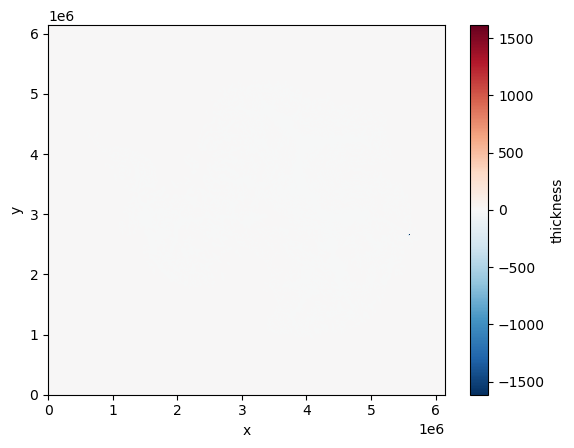

In [25]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminated.nc')
dthk = file.thickness.isel(time=-1) - file.thickness.isel(time=0)
dthk.plot()

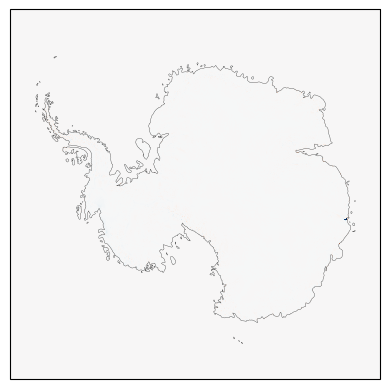

In [30]:
from lib.myplots import spatial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
spatial(ax, dthk, vmax=50, vmin=-50, cmap='RdBu_r')
plt.show()

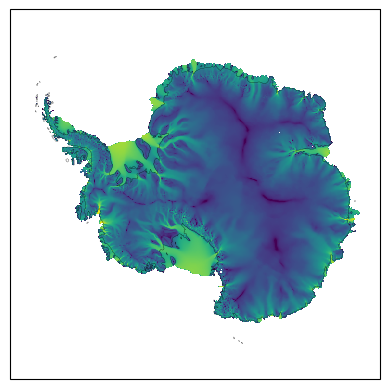

In [33]:
from matplotlib.colors import LogNorm
u = np.hypot(file.xVel, file.yVel)

fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
spatial(ax, u.isel(time=-1), norm=LogNorm(vmin=1), cmap='viridis')
plt.show()

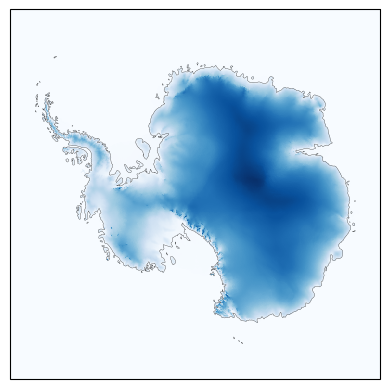

In [38]:
thk = file.Z_surface.isel(time=-1)
fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
spatial(ax, thk, cmap='Blues')
plt.show()

In [39]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/MRI-ESM2-0_thermal_forcing_8km_x_60m.nc')
file

<xarray.Dataset> Size: 3GB
Dimensions:          (x: 761, y: 761, z: 30, nbounds: 2, time: 20)
Coordinates:
  * x                (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * y                (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * z                (z) float64 240B -30.0 -90.0 -150.0 ... -1.71e+03 -1.77e+03
  * time             (time) object 160B 1995-01-01 00:00:00 ... 2014-01-01 00...
Dimensions without coordinates: nbounds
Data variables:
    z_bnds           (z, nbounds) float64 480B ...
    thermal_forcing  (time, z, y, x) float64 3GB ...

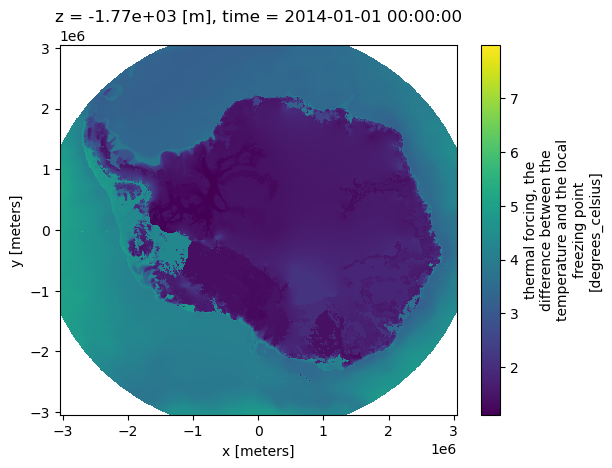

In [45]:
file.thermal_forcing.isel(z=-1, time=-1).plot()

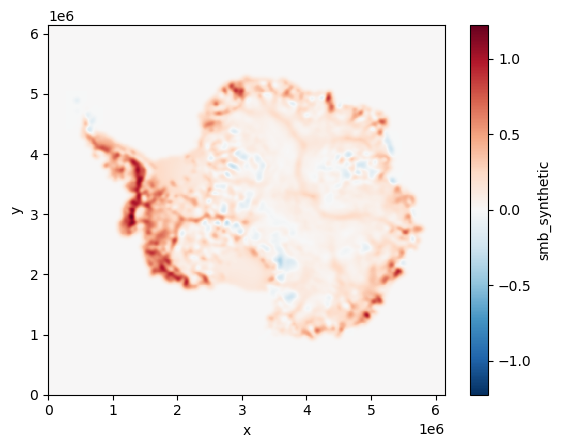

In [46]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_synthetic_smb.nc')
file.smb_synthetic.plot()

(2007.0, 2008.0)

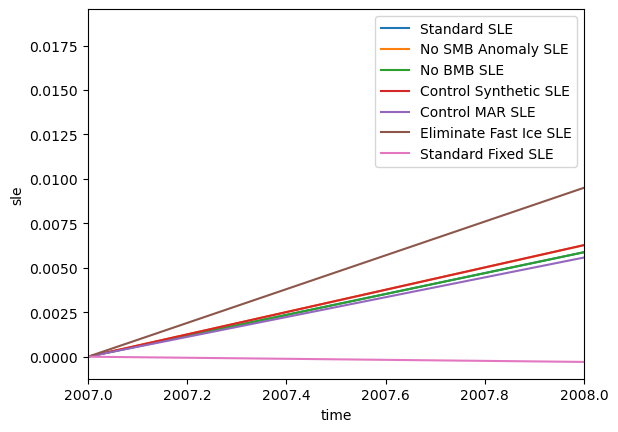

In [77]:
from slepy import SLECalculator
standard_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/standard.nc')
no_smb_anom_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/no_smb_anom.nc')
no_bmb_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/no_bmb.nc')
control_synthetic_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/control_synthetic.nc')
control_MAR_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/control_MAR.nc')
eliminate_fast_ice_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/eliminate_fast_ice.nc')
standard_fixed_file = xr.open_dataset('/Users/jonniebarnsley/Downloads/standard_fixed.nc')

with SLECalculator() as calc:
    standard_sle = calc.calculate_sle(standard_file.thickness, standard_file.Z_base)
    no_smb_anom_sle = calc.calculate_sle(no_smb_anom_file.thickness, no_smb_anom_file.Z_base)
    no_bmb_sle = calc.calculate_sle(no_bmb_file.thickness, no_bmb_file.Z_base)
    control_synthetic_sle = calc.calculate_sle(control_synthetic_file.thickness, control_synthetic_file.Z_base)
    control_MAR_sle = calc.calculate_sle(control_MAR_file.thickness, control_MAR_file.Z_base)
    eliminate_fast_ice_sle = calc.calculate_sle(eliminate_fast_ice_file.thickness, eliminate_fast_ice_file.Z_base)
    standard_fixed_sle = calc.calculate_sle(standard_fixed_file.thickness, standard_fixed_file.Z_base)

standard_sle.plot(label='Standard SLE')
no_smb_anom_sle.plot(label='No SMB Anomaly SLE')
no_bmb_sle.plot(label='No BMB SLE')
control_synthetic_sle.plot(label='Control Synthetic SLE')
control_MAR_sle.plot(label='Control MAR SLE')
eliminate_fast_ice_sle.plot(label='Eliminate Fast Ice SLE')
standard_fixed_sle.plot(label='Standard Fixed SLE')

plt.legend()
plt.xlim(2007, 2008)
#plt.ylim(0, 0.01)

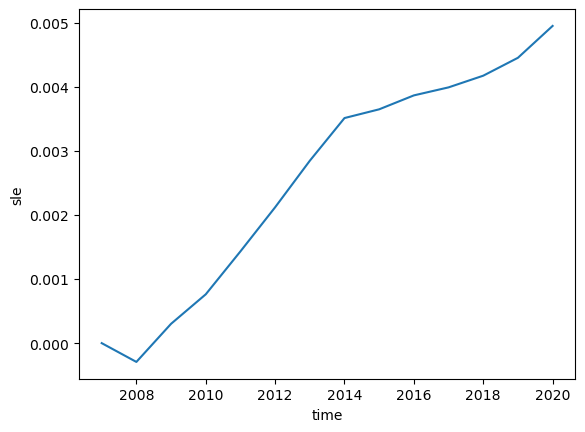

In [79]:
standard_fixed_sle.plot()

In [75]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/standard_fixed.nc')
file

<xarray.Dataset> Size: 57MB
Dimensions:       (time: 2, y: 768, x: 768)
Coordinates:
  * x             (x) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
  * y             (y) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
  * time          (time) float64 16B 2.007e+03 2.008e+03
Data variables:
    thickness     (time, y, x) float64 9MB ...
    dThicknessdt  (time, y, x) float64 9MB ...
    xVel          (time, y, x) float64 9MB ...
    yVel          (time, y, x) float64 9MB ...
    Z_base        (time, y, x) float64 9MB ...
    Z_surface     (time, y, x) float64 9MB ...

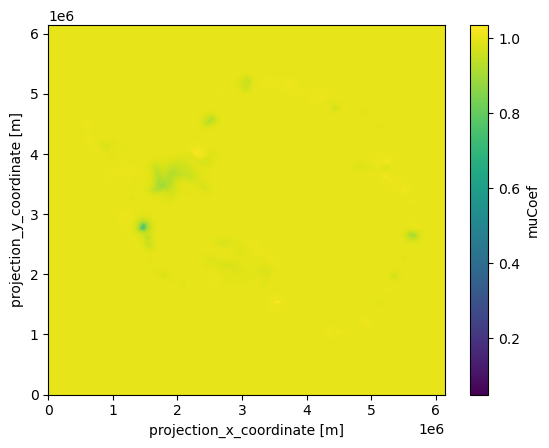

In [17]:
import xarray as xr
from slepy import SLECalculator

file = xr.open_dataset('/Users/jonniebarnsley/Downloads/test.nc')
file.muCoef.plot(vmin=0.05)

In [14]:
from lib.animation import animate
import numpy as np
from matplotlib.colors import LogNorm
u = np.hypot(file.xVel, file.yVel)
measures = xr.open_dataset("/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_ice_velocity_v2_8km.nc")
uobs = np.hypot(measures.VX, measures.VY)
uobs = uobs.rename({'x': 'y', 'y': 'x'})
misfit = u - uobs
misfit = misfit.isel(x = slice(150, 200), y = slice(300, 400))

anim = animate(misfit)
anim.save('/Users/jonniebarnsley/Downloads/velocity_animation4.mp4', fps=10)

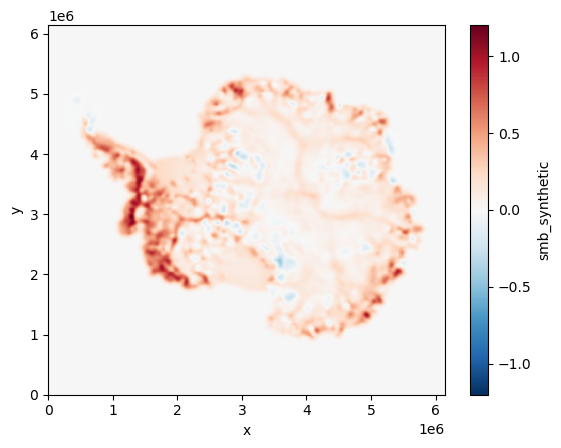

In [22]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_synthetic_smb.nc')
file.smb_synthetic.plot()

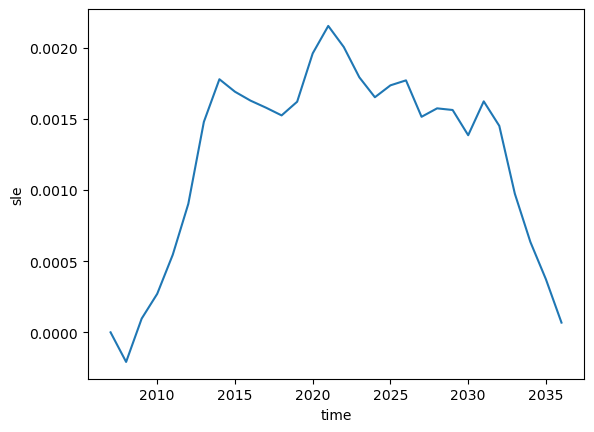

In [11]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_fast_ice_ssp585.nc')
with SLECalculator() as calc:
    sle = calc.calculate_sle(file.thickness, file.Z_base, sum=False)
sle.sum(dim=['x', 'y']).plot()

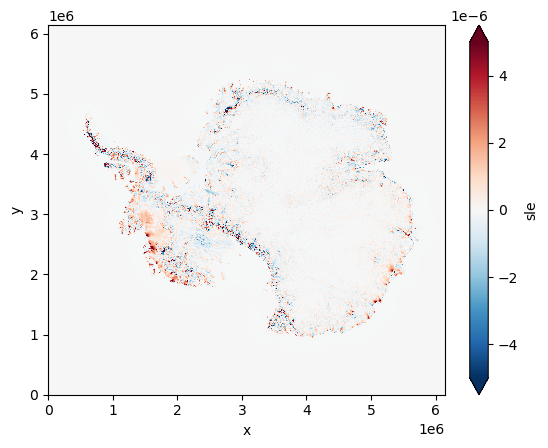

In [7]:
diff = sle.sel(time=2020) - sle.isel(time=0)
diff.plot(vmin=-5e-6, vmax=5e-6, cmap='RdBu_r')

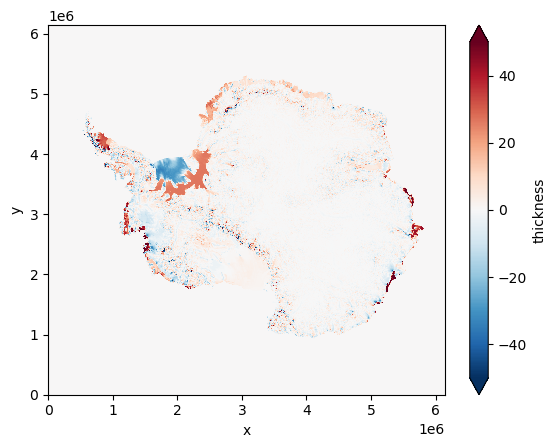

In [10]:
diff = file.thickness.sel(time=2020) - file.thickness.isel(time=0)
diff.plot(vmin=-50, vmax=50, cmap='RdBu_r')

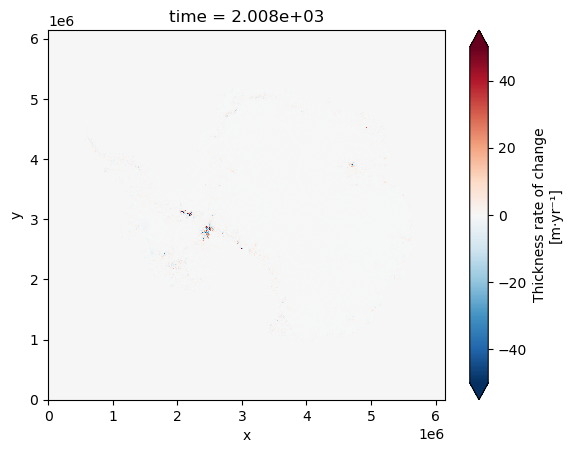

In [5]:
file.dThicknessdt.isel(time=1).plot(vmin=-50, vmax=50, cmap='RdBu_r')

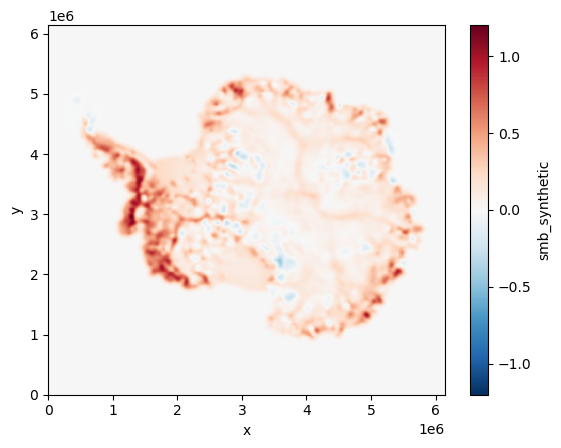

In [41]:
smb = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_synthetic_smb.nc').smb_synthetic
smb.plot()

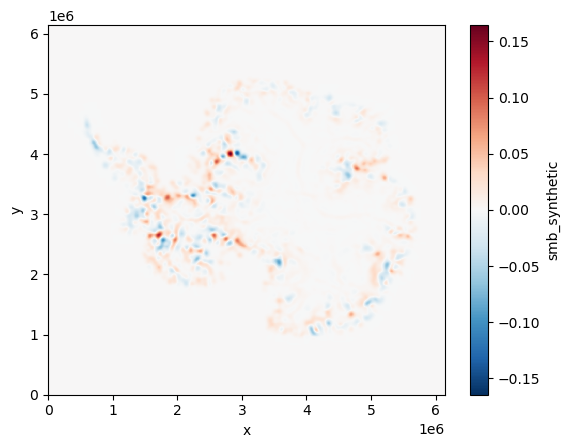

In [64]:
old_smb = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_synthetic_smb.nc').smb_synthetic
(smb - old_smb).plot()

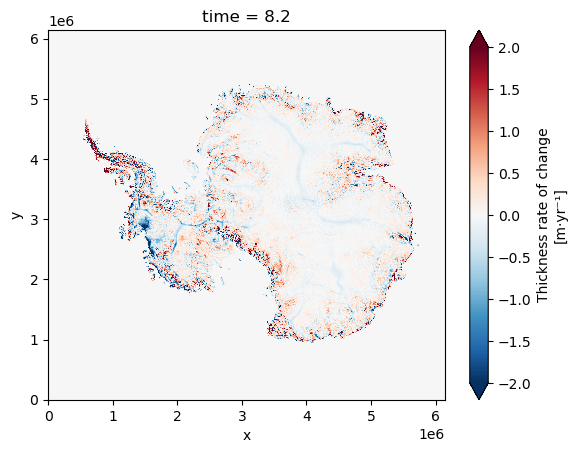

In [59]:
inv = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_fast_ice_inv.nc')
inv.dThicknessdt.isel(time=-5).plot(vmin=-2, vmax=2, cmap='RdBu_r')

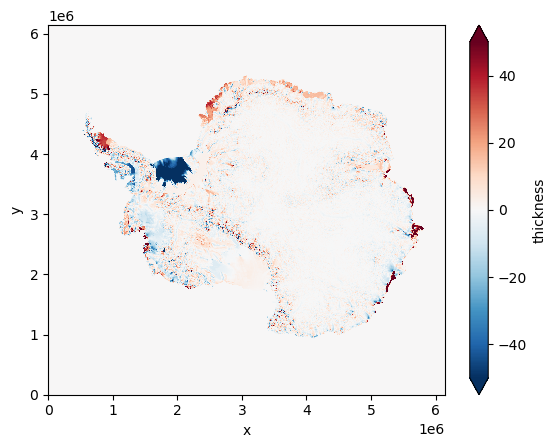

In [60]:
dthk = file.thickness.isel(time=20) - file.thickness.isel(time=0)
dthk.plot(vmin=-50, vmax=50, cmap='RdBu_r')

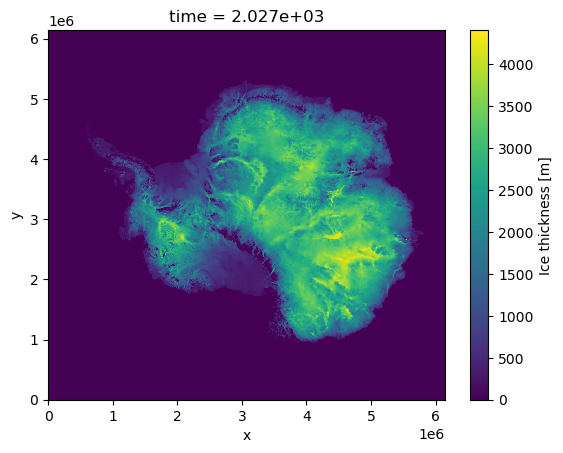

In [61]:
file.thickness.isel(time=20).plot()

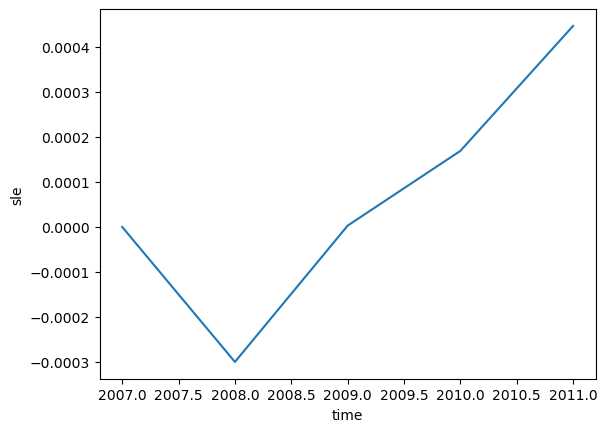

In [3]:
from slepy import SLECalculator
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/eliminate_inv_dont_forward_ssp585.nc')
with SLECalculator() as calc:
    sle = calc.calculate_sle(file.thickness, file.Z_base, sum=False)
sle.sum(dim=['x', 'y']).plot()

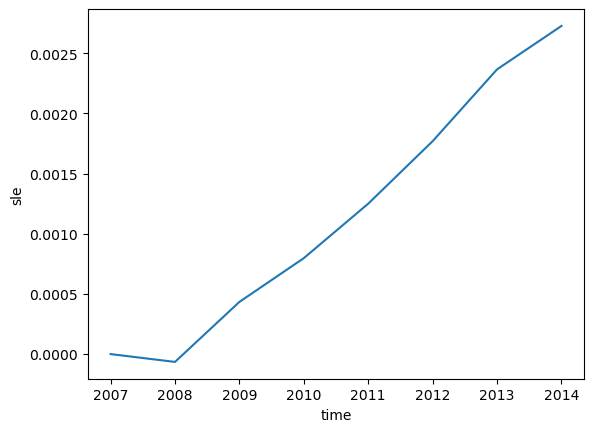

In [12]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_fast_ice_15yr_relax.nc')
with SLECalculator() as calc:
    sle = calc.calculate_sle(file.thickness, file.Z_base, sum=False)
sle.sum(dim=['x', 'y']).plot()

In [13]:
sle.sum(dim=['x', 'y']).values

array([ 0.00000000e+00, -6.50481382e-05,  4.33713625e-04,  7.97529245e-04,
        1.25039579e-03,  1.76968922e-03,  2.36655111e-03,  2.72757210e-03])

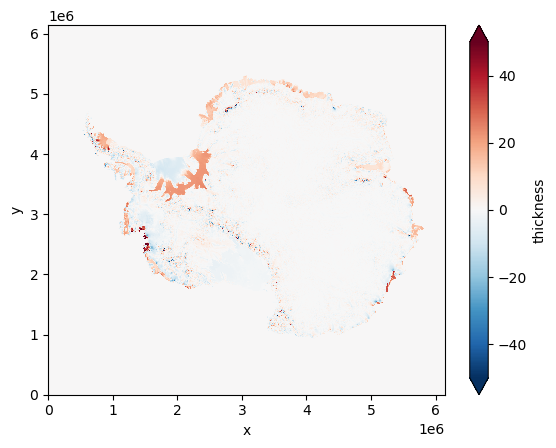

In [14]:
dthk = file.thickness.isel(time=-1) - file.thickness.isel(time=0)
dthk.plot(vmin=-50, vmax=50, cmap='RdBu_r')

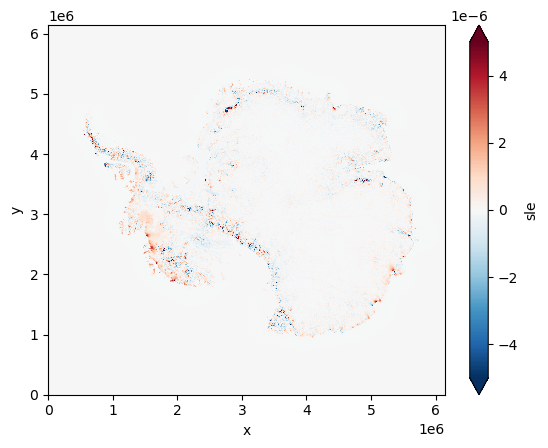

In [15]:
dsle = sle.isel(time=-1) - sle.isel(time=0)
dsle.plot(vmin=-5e-6, vmax=5e-6, cmap='RdBu_r')

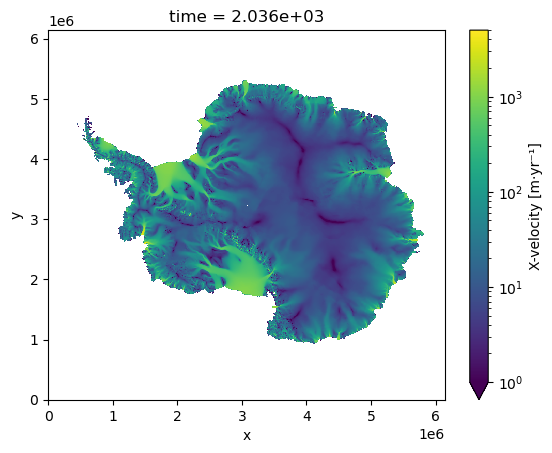

In [27]:
from matplotlib.colors import LogNorm
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_eliminate_fast_ice_ssp585.nc')
umod = np.hypot(file.xVel, file.yVel)
umod.isel(time=-1).plot(cmap='viridis', norm=LogNorm(vmin=1, vmax=5e3))

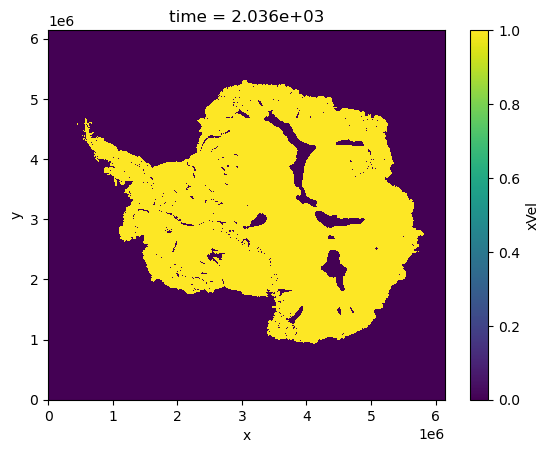

In [31]:
(umod > 4).astype(int).isel(time=-1).plot()

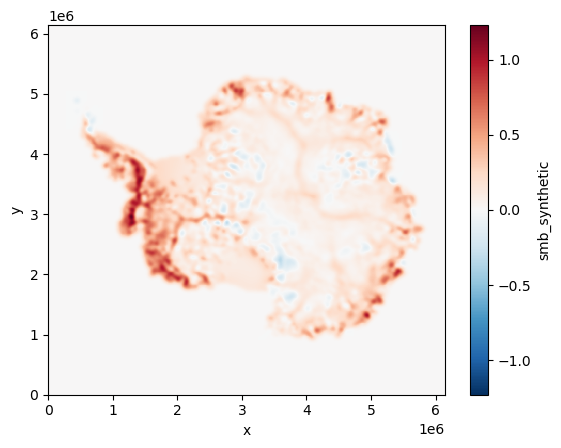

In [32]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/synthetic_smb_new/ppe_run001_synthetic_smb.nc')
file.smb_synthetic.plot()

In [61]:
from pathlib import Path
path = Path('/Users/jonniebarnsley/Downloads/ssp534-test')
with SLECalculator() as calc:
    sle = calc.process_ensemble(path)

    Run 1/8: AIS_p001_ssp534-over_8km
    Run 2/8: AIS_p002_ssp534-over_8km
    Run 3/8: AIS_p003_ssp534-over_8km
    Run 4/8: AIS_p004_ssp534-over_8km
    Run 5/8: AIS_p005_ssp534-over_8km
    Run 6/8: AIS_p006_ssp534-over_8km
    Run 7/8: AIS_p007_ssp534-over_8km
    Run 8/8: AIS_p008_ssp534-over_8km


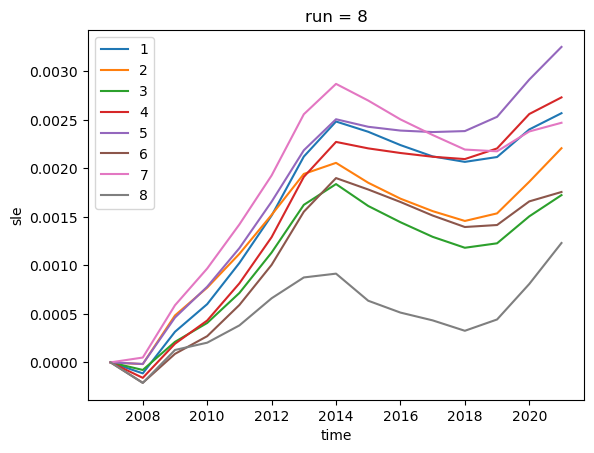

In [54]:
import matplotlib.pyplot as plt
for run in sle.run:
    sle.sel(run=run).plot(label=str(run.item()))

plt.legend()

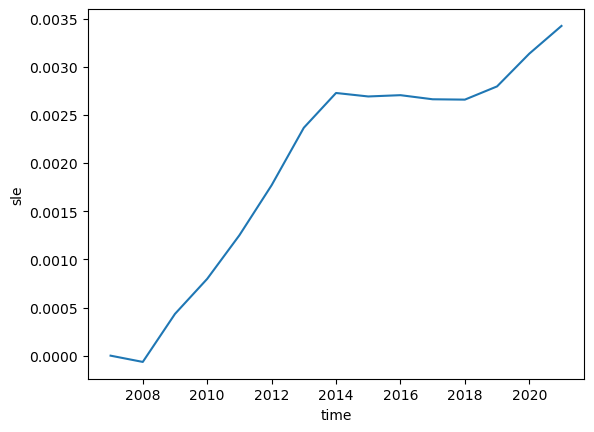

In [55]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/test.nc')
with SLECalculator() as calc:
    sle = calc.calculate_sle(file.thickness, file.Z_base, sum=False)
sle.sum(dim=['x', 'y']).plot()

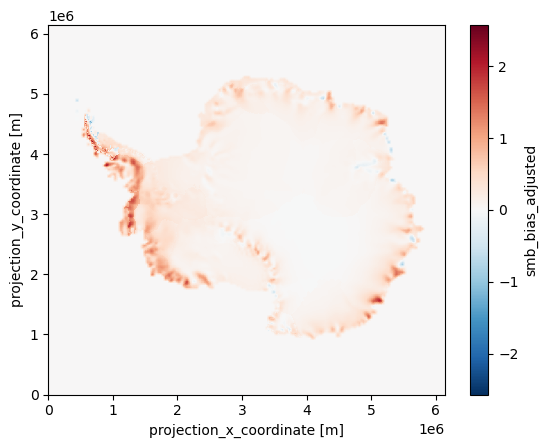

In [56]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/bias_adjusted_smb/ppe_run001_bias_adjusted_smb.nc')
file.smb_bias_adjusted.plot()

In [57]:
from pathlib import Path
path = Path('/Users/jonniebarnsley/Downloads/ssp534-over_bias_adjusted_smb')

with SLECalculator() as calc:
    sle = calc.process_ensemble(path)

    Run 1/8: plot_AIS_inversion_p001_8km
    Run 2/8: plot_AIS_inversion_p002_8km
    Run 3/8: plot_AIS_inversion_p003_8km
    Run 4/8: plot_AIS_inversion_p004_8km
    Run 5/8: plot_AIS_inversion_p005_8km
    Run 6/8: plot_AIS_inversion_p006_8km
    Run 7/8: plot_AIS_inversion_p007_8km
    Run 8/8: plot_AIS_inversion_p008_8km


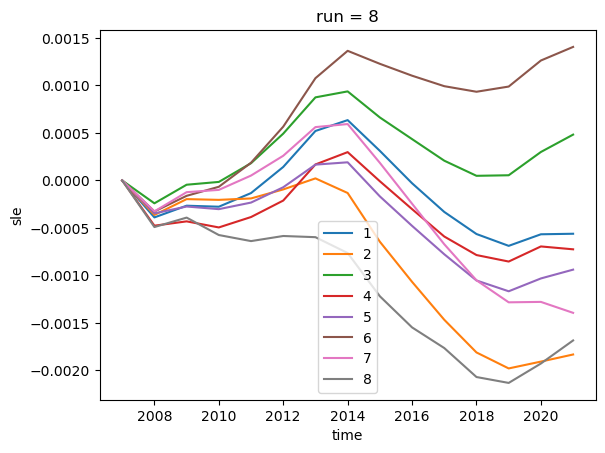

In [58]:
for run in sle.run:
    sle.sel(run=run).plot(label=str(run.item()))
plt.legend()

In [63]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/ssp534-test/AIS_p002_ssp534-over_8km.nc')
umod = np.hypot(file.xVel, file.yVel)

In [67]:
for year in umod.time:
    print(umod.sel(time=year).max().item())

4371.426931092638
3699.8797654759
4201.954178931751
11153.086911810604
3785.7672425870296
3835.5099282407027
3759.7202061070984
3803.958232422249
3740.318836971656
3890.8363942371057
3753.6733242457312
3884.092196742245
3791.8207407899704
10037.149512226319
3567.316308680519


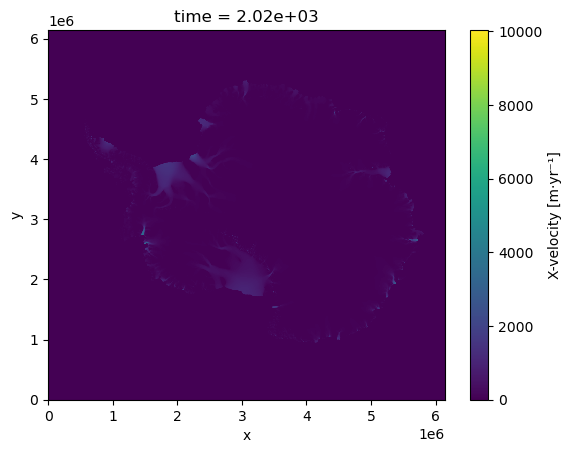

In [69]:
umod.isel(time=-2).plot()

In [74]:
def plot_max_location(da, ax=None, **imshow_kwargs):
    """
    Plot a DataArray and mark the location of its maximum with an 'x'.

    Parameters
    ----------
    da : xarray.DataArray
        2D DataArray with dimensions (x, y)
    ax : matplotlib.axes.Axes, optional
        Existing axes to plot on
    **imshow_kwargs :
        Passed to ax.imshow

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the field
    da.plot.imshow(ax=ax, **imshow_kwargs)

    # Find max location
    max_idx = da.argmax(dim=("x", "y"))
    x_max = da["x"].values[max_idx["x"].item()]
    y_max = da["y"].values[max_idx["y"].item()]

    print(f"x_max: {x_max}", f"y_max: {y_max}", sep="\n")

    # Plot marker
    ax.plot(x_max, y_max, "x", color="red", markersize=10, mew=2)

    return ax


x_max: 788000.0
y_max: 3972000.0


<Axes: title={'center': 'time = 2.02e+03'}, xlabel='x', ylabel='y'>

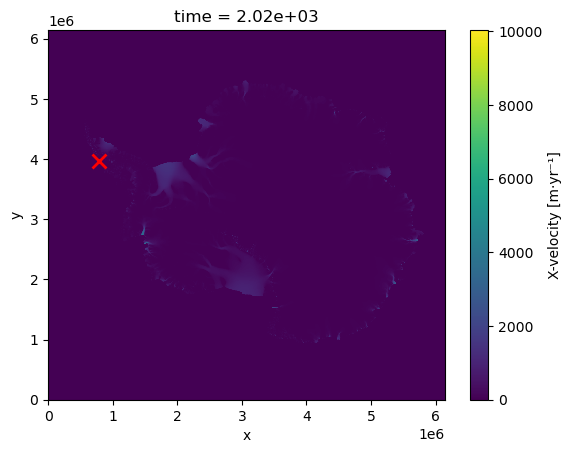

In [75]:
plot_max_location(umod.isel(time=-2))

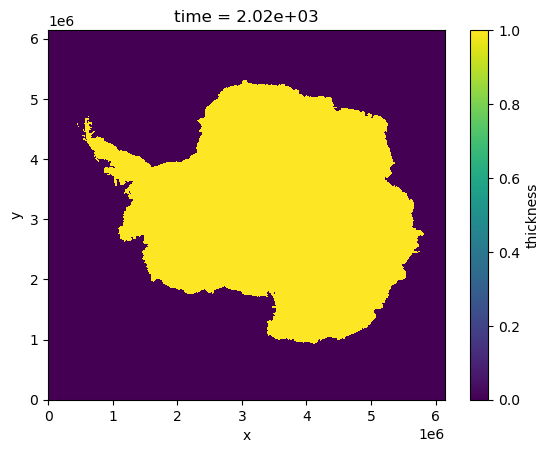

In [80]:
mask = file.isel(time=-2).thickness > 0

fig, ax = plt.subplots()
mask.plot(ax=ax)
#ax.plot(788000.0, 3972000.0, "x", color="red", markersize=10, mew=2)

In [83]:
d = {'a': 1, 'b': 2}
sorted(d.keys())

['a', 'b']

In [84]:
path = Path('/Users/jonniebarnsley/data/anomaly_585/MRI-ESM2-0')
files = sorted(path.iterdir())
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 306, y: 768, x: 768)
Coordinates:
    height       float64 8B 2.0
  * time         (time) int64 2kB 1995 1996 1997 1998 ... 2297 2298 2299 2300
    lat          (y, x) float64 5MB dask.array<chunksize=(768, 768), meta=np.ndarray>
    lon          (y, x) float64 5MB dask.array<chunksize=(768, 768), meta=np.ndarray>
  * x            (x) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
  * y            (y) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
Data variables:
    smb_anomaly  (time, y, x) float64 1GB dask.array<chunksize=(1, 768, 768), meta=np.ndarray>
Attributes:
    long_name:      Surface Mass Balance Anomaly
    standard_name:  smb_anomaly
    description:    Surface Mass Balance anomaly relative to 1995-2014 climat...
    units:          m a-1

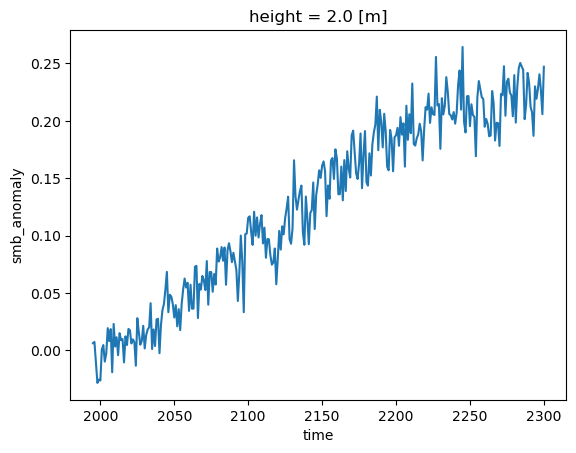

In [85]:
ts = ds.mean(dim=['x', 'y'])
ts.smb_anomaly.plot()